In [1]:
!pip install -e /dss/dsshome1/04/di93zer/git/cellnet --no-deps

Obtaining file:///dss/dsshome1/04/di93zer/git/cellnet
  Preparing metadata (setup.py) ... done
  Attempting uninstall: cellnet
    Found existing installation: cellnet 0.1.0
    Can't uninstall 'cellnet'. No files were found to uninstall.
  Running setup.py develop for cellnet

[notice] A new release of pip is available: 23.1.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
!pip install -q SPARQLWrapper


[notice] A new release of pip is available: 23.1.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip


In [3]:
# !pip install -q cellxgene-census
!pip install -q obonet


[notice] A new release of pip is available: 23.1.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip


In [1]:
%load_ext autoreload

In [2]:
import pickle
import os
from os.path import join


import numpy as np
import pandas as pd
import seaborn as sns
import scanpy as sc
import matplotlib.pyplot as plt
import dask.dataframe as dd
import lightning.pytorch as pl
import torch

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Create Ontology ID to cell type label mapping

In [ ]:
census = cellxgene_census.open_soma(census_version="2023-05-15")
summary = census["census_info"]['summary']
protocols = [
    "10x 5' v2", 
    "10x 3' v3", 
    "10x 3' v2", 
    "10x 5' v1", 
    "10x 3' v1", 
    "10x 3' transcription profiling", 
    "10x 5' transcription profiling"
]
obs = (
    census["census_data"]["homo_sapiens"]
    .obs
    .read(
        column_names=["cell_type", "cell_type_ontology_term_id"],
        value_filter=f"is_primary_data == True and assay in {protocols}"
    )
    .concat().to_pandas()
)
id_mapping = obs[['cell_type', 'cell_type_ontology_term_id']].drop_duplicates()
id_mapping.to_parquet('model_eval_cache/id_mapping.parquet')

## Pre-calculate predictions

In [3]:
DATA_PATH = '/mnt/dssmcmlfs01/merlin_cxg_2023_05_15_sf-log1p'
CKPT_PATH_TABNET = '/mnt/dssfs02/tb_logs/cxg_2023_05_15_tabnet/default/w_augment_4/checkpoints/val_f1_macro_epoch=45_val_f1_macro=0.847.ckpt'
CKPT_PATH_LINEAR = '/mnt/dssfs02/tb_logs/juwles/cxg_2023_05_15_linear/default/version_1/checkpoints/val_f1_macro_epoch=33_val_f1_macro=0.773.ckpt'

In [4]:
from predictions import eval_tabnet, eval_linear

/usr/local/lib/python3.8/dist-packages/merlin/dtypes/mappings/tf.py:52: UserWarning: Tensorflow dtype mappings did not load successfully due to an error: No module named 'tensorflow'
  warn(f"Tensorflow dtype mappings did not load successfully due to an error: {exc.msg}")


In [5]:
if not os.path.isfile('model_eval_cache/preds_tabnet.pkl'):
    preds_tabnet = eval_tabnet([CKPT_PATH_TABNET], DATA_PATH)[0]
    # save predictions to disk
    with open('model_eval_cache/preds_tabnet.pkl', 'wb') as f:
        pickle.dump(preds_tabnet, f)
else:
    # load cached predictions
    with open('model_eval_cache/preds_tabnet.pkl', 'rb') as f:
        preds_tabnet = pickle.load(f)

        
if not os.path.isfile('model_eval_cache/preds_linear.pkl'):
    preds_linear = eval_linear([CKPT_PATH_LINEAR], DATA_PATH)[0]
    # save predictions to disk
    with open('model_eval_cache/preds_linear.pkl', 'wb') as f:
        pickle.dump(preds_linear, f)
else:
    # load cached predictions
    with open('model_eval_cache/preds_linear.pkl', 'rb') as f:
        preds_linear = pickle.load(f)

## Define cell type grouping

In [6]:
id_mapping = (
    pd.read_parquet('model_eval_cache/id_mapping.parquet')
    .set_index('cell_type_ontology_term_id')
    ['cell_type']
    .to_dict()
)

In [7]:
cell_type_mapping = pd.read_parquet(join(DATA_PATH, 'categorical_lookup/cell_type.parquet'))

In [8]:
import obonet
import networkx


url = 'https://github.com/obophenotype/cell-ontology/releases/download/v2023-08-24/cl-simple.obo'
graph = obonet.read_obo(url, ignore_obsolete=True)

# only use "is_a" edges
edges_to_delete = []
for i, x in enumerate(graph.edges):
    if x[2] != 'is_a':
        edges_to_delete.append((x[0], x[1]))
for x in edges_to_delete:
    graph.remove_edge(u=x[0], v=x[1])

# define mapping from id to name
id_to_name = {id_: data.get('name') for id_, data in graph.nodes(data=True)}
# define inverse mapping from name to id
name_to_id = {v: k for k, v in id_to_name.items()}


def find_child_nodes(cell_type):
    return [id_to_name[node] for node in networkx.ancestors(graph, name_to_id[cell_type])]


def find_parent_nodes(cell_type):
    return [id_to_name[node] for node in networkx.descendants(graph, name_to_id[cell_type])]


In [9]:
from SPARQLWrapper import SPARQLWrapper, JSON
import csv

# Set up the SPARQL endpoint
sparql = SPARQLWrapper("https://ubergraph.apps.renci.org/sparql")
# Set the SPARQL query
sparql.setQuery(
f"""
PREFIX CL: <http://purl.obolibrary.org/obo/CL_>

SELECT ?cell ?ic_score
WHERE {{
  ?cell <http://reasoner.renci.org/vocab/normalizedInformationContent> ?ic_score .
  VALUES ?cell {{ {' '.join(list(id_mapping.keys()))} }}
}}
"""
)

# Set the return format as JSON
sparql.setReturnFormat(JSON)

# Use POST method
sparql.method = 'POST'

# Execute the query
results = sparql.query().convert()

# Extract relevant data
bindings = results['results']['bindings']
ic_scores = {}
for binding in bindings:
    cell = id_mapping[str(binding['cell']['value']).lstrip('http://purl.obolibrary.org/obo/').replace('_', ':')]
    ic_scores[cell] = float(binding['ic_score']['value'])


<Axes: ylabel='Count'>

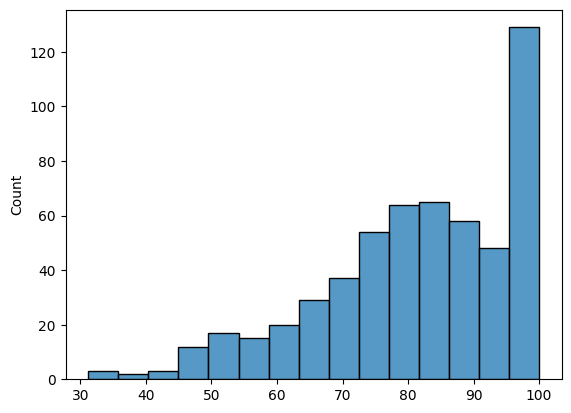

In [10]:
import seaborn as sns
import numpy as np


sns.histplot(list(ic_scores.values()))

In [11]:
coarse_labels = [(k, v) for k, v in ic_scores.items() if v <= 60]
# sort labels by IC score
coarse_labels = [k for k, _ in sorted(coarse_labels, key=lambda x: -x[1])]
# subset to subtypes of "native cell"
native_cell_subtypes = find_child_nodes('native cell')
coarse_labels = [elem for elem in coarse_labels if elem in native_cell_subtypes]

In [12]:
from cellnet.utils.cell_ontology import retrieve_child_nodes_from_ubergraph


grouping = {label: [] for label in coarse_labels}
labels = list(ic_scores.keys())

for coarse in coarse_labels:
    subtypes = find_child_nodes(coarse) + [coarse]
    added_types = []
    for elem in labels:
        if elem in subtypes:
            grouping[coarse].append(elem)
            added_types.append(elem)
    
    for elem in added_types:
        labels.remove(elem)

grouping = {k: [elem for elem in v if elem in cell_type_mapping.label.tolist()] for k, v in grouping.items()}
grouping = {k: v for k, v in grouping.items() if v}

In [13]:
len(grouping)

31

In [14]:
len(sum(grouping.values(), []))

164

In [15]:
list(grouping.keys())

['erythroid lineage cell',
 'mature T cell',
 'glandular epithelial cell',
 'phagocyte',
 'fibroblast',
 'myeloid leukocyte',
 'B cell',
 'T cell',
 'professional antigen presenting cell',
 'columnar/cuboidal epithelial cell',
 'hematopoietic stem cell',
 'blood cell',
 'blood vessel endothelial cell',
 'endothelial cell of vascular tree',
 'endothelial cell',
 'hematopoietic precursor cell',
 'glial cell',
 'squamous epithelial cell',
 'neuron associated cell',
 'inhibitory interneuron',
 'neuronal receptor cell',
 'lymphocyte',
 'glutamatergic neuron',
 'progenitor cell',
 'connective tissue cell',
 'leukocyte',
 'muscle cell',
 'stem cell',
 'epithelial cell',
 'interneuron',
 'neuron']

In [16]:
from cellnet.utils.cell_ontology import retrieve_child_nodes_from_ubergraph


# define hierachy matrices + cell type mapping
coarse_celltype_mapping = {i: celltype for i, celltype in enumerate(sorted(grouping.keys()))}
inverse_mapping = {v: k for k, v in coarse_celltype_mapping.items()}
celltypes = list(grouping.keys())
child_nodes_dict = {}
for k, v in {k: find_child_nodes(k) for k in celltypes}.items():
    child_nodes_dict[k] = [elem for elem in v if elem in celltypes]

children_idx = []
for cell_type in coarse_celltype_mapping.values():
    child_nodes = child_nodes_dict[cell_type]
    children_idx.append([inverse_mapping[node] for node in child_nodes])

child_matrix = np.eye(len(coarse_celltype_mapping))
for i, child_nodes in enumerate(children_idx):
    child_matrix[i, child_nodes] = 1.


## Evaluation on coarse cell type labels (Reviewer #1 - comment 2)

In [17]:
from utils import correct_labels
from sklearn.metrics import classification_report

In [18]:
y_true = dd.read_parquet(join(DATA_PATH, 'test'), columns='cell_type').compute().to_numpy()
cell_type_mapping = pd.read_parquet(join(DATA_PATH, 'categorical_lookup/cell_type.parquet'))
inverse_cell_type_mapping = {v: k for k, v in cell_type_mapping.label.to_dict().items()}

In [19]:
y_true_coarse = np.ones(y_true.shape, dtype='i8') * -1

for coarse, fine in grouping.items():
    y_true_coarse[
        np.isin(y_true, [inverse_cell_type_mapping[elem] for elem in fine])
    ] = inverse_mapping[coarse]


### TabNet

In [20]:
preds_tabnet_coarse = np.ones(preds_tabnet.shape, dtype='i8') * -1

for coarse, fine in grouping.items():
    preds_tabnet_coarse[
        np.isin(preds_tabnet, [inverse_cell_type_mapping[elem] for elem in fine])
    ] = inverse_mapping[coarse]

In [21]:
preds_tabnet_coarse = correct_labels(y_true_coarse, preds_tabnet_coarse, child_matrix)
clf_report = pd.DataFrame(classification_report(y_true_coarse, preds_tabnet_coarse, output_dict=True)).T
clf_report_overall = clf_report.iloc[-3:].copy()
clf_report_per_class = clf_report.iloc[:-3].copy()

clf_report_overall

,precision,recall,f1-score,support
accuracy,0.958956,0.958956,0.958956,9.589560e-01
macro avg,0.896106,0.905767,0.897629,3.448832e+06
weighted avg,0.960779,0.958956,0.959255,3.448832e+06


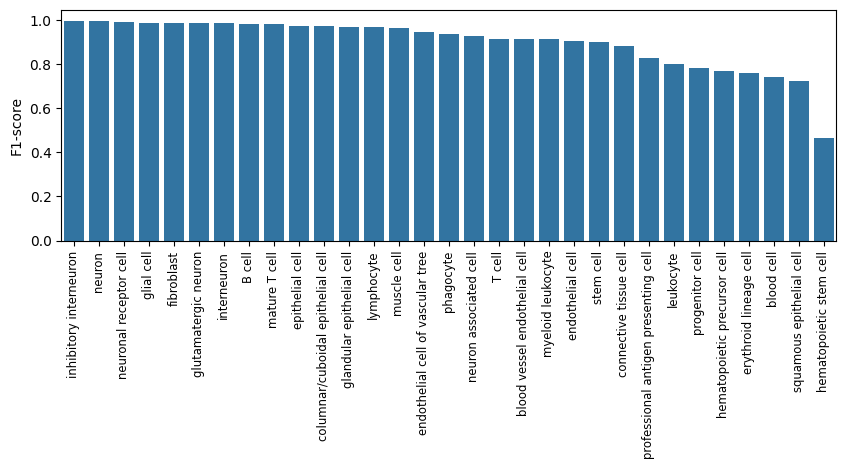

In [22]:
plt.rcParams['figure.figsize'] = (10, 3)

ax = sns.barplot(
    data=(
        clf_report_per_class
        .assign(
            cell_type=lambda df: df.index.to_series().astype(int).replace(coarse_celltype_mapping)
        )
        .sort_values('f1-score', ascending=False)
    ),
    x='cell_type',
    y='f1-score',
    color='#1f77b4'
)
ax.tick_params(axis='x', labelrotation=90)
ax.set_xlabel('')
ax.set_ylabel('F1-score')
ax.xaxis.set_tick_params(labelsize='small');

### Optimized linear

In [23]:
preds_linear_coarse = np.ones(preds_linear.shape, dtype='i8') * -1

for coarse, fine in grouping.items():
    preds_linear_coarse[
        np.isin(preds_linear, [inverse_cell_type_mapping[elem] for elem in fine])
    ] = inverse_mapping[coarse]

In [24]:
preds_linear_coarse = correct_labels(y_true_coarse, preds_linear_coarse, child_matrix)
clf_report = pd.DataFrame(classification_report(y_true_coarse, preds_linear_coarse, output_dict=True)).T
clf_report_overall = clf_report.iloc[-3:].copy()
clf_report_per_class = clf_report.iloc[:-3].copy()

clf_report_overall

,precision,recall,f1-score,support
accuracy,0.941015,0.941015,0.941015,9.410154e-01
macro avg,0.874771,0.902698,0.883123,3.448832e+06
weighted avg,0.945913,0.941015,0.942128,3.448832e+06


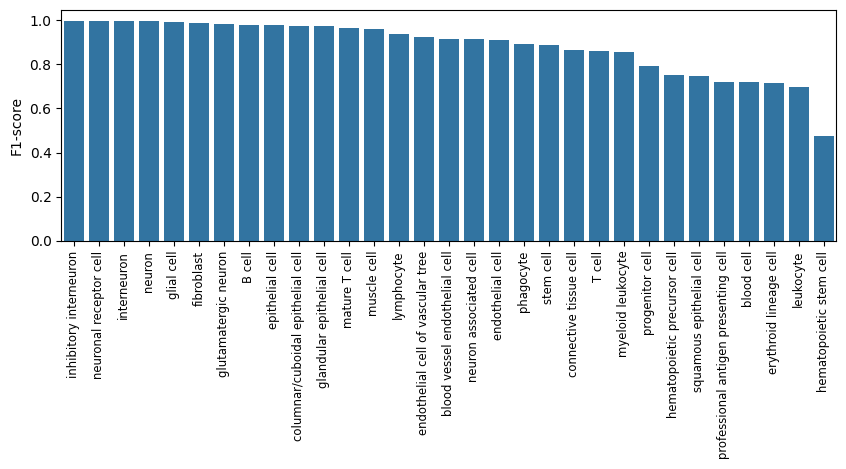

In [25]:
plt.rcParams['figure.figsize'] = (10, 3)

ax = sns.barplot(
    data=(
        clf_report_per_class
        .assign(
            cell_type=lambda df: df.index.to_series().astype(int).replace(coarse_celltype_mapping)
        )
        .sort_values('f1-score', ascending=False)
    ),
    x='cell_type',
    y='f1-score',
    color='#1f77b4'
)
ax.tick_params(axis='x', labelrotation=90)
ax.set_xlabel('')
ax.set_ylabel('F1-score')
ax.xaxis.set_tick_params(labelsize='small');